In [ ]:
pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 20.8 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Configuration and Hyperparameters

import time
import numpy as np
import pandas as pd
import torch
import faiss
import torchvision.transforms as T
from sentence_transformers import SentenceTransformer
from timm import create_model
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

N_LIST       = 150    
M_PQ         = 8     
K_NEIGHBORS  = 50     
THRESHOLD    = 0.7    
BATCH_SIZE   = 64     
VISUAL_COUNT = 5      

In [17]:
import pandas as pd

# Load dataset
df = pd.read_csv('/kaggle/input/shopee/train.csv')
df['image_path'] = df['image'].map(lambda x: f"/kaggle/input/shopee/train_images/{x}")

# Get user input
user_input = input("Enter one or more query indices (comma-separated, e.g., 0, 12, 107): ")
try:
    candidate_queries = [int(idx.strip()) for idx in user_input.split(',') if idx.strip().isdigit()]
except ValueError:
    print("Invalid input. Please enter only numbers separated by commas.")
    candidate_queries = []

# Print query details
for query_idx in candidate_queries:
    print("\n---")
    print("Will demo on index:", query_idx)
    print("Title       :", df.iloc[query_idx]['title'])
    print("Image path  :", df.iloc[query_idx]['image_path'])

if not candidate_queries:
    print("\nNo valid indices provided.")
else:
    print("\nDemo indices used:", candidate_queries)


Enter one or more query indices (comma-separated, e.g., 0, 12, 107):  0,12,107,1, 523, 892, 1430



---
Will demo on index: 0
Title       : Paper Bag Victoria Secret
Image path  : /kaggle/input/shopee/train_images/0000a68812bc7e98c42888dfb1c07da0.jpg

---
Will demo on index: 12
Title       : PASHMINA KUSUT RAWIS POLOS CRINKLE SHAWL MURAH BANGET PART 2
Image path  : /kaggle/input/shopee/train_images/001e11145b8e9bf5ac51110c0fdd8697.jpg

---
Will demo on index: 107
Title       : Tali Ikat Pinggang Pria Canvas Army Military Tactical 125cm
Image path  : /kaggle/input/shopee/train_images/00e3e2ddacb5902fbd98dcb0a5d96ab9.jpg

---
Will demo on index: 1
Title       : Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE
Image path  : /kaggle/input/shopee/train_images/00039780dfc94d01db8676fe789ecd05.jpg

---
Will demo on index: 523
Title       : [BISA COD ] Mecca Syari S M L XL | Fashion Muslim Gamis Syari Terbaru | Bahan Moscrepe HQ
Image path  : /kaggle/input/shopee/train_images/04352cb66c9f237ae435308ca48cea2e.jpg

---
Will demo on index: 892
Title       : KING_FASHION  LEST PANTS

In [ ]:
# Dataset Class for Image Loading
class ImageDataset(Dataset):
    """Simple wrapper to load and transform images."""
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.transform(img)

def log_time(t0, msg):
    print(f"{msg}: {time.time() - t0:.2f}s")
    return time.time()

# Load on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Image embedding model: eca_nfnet_l1
img_model = create_model('eca_nfnet_l1', pretrained=True, num_classes=0).to(device).eval()

# Text embedding model: multilingual paraphrase transformer
txt_model = SentenceTransformer('paraphrase-xlm-r-multilingual-v1', device=device)

Using device: cuda


In [ ]:
t0 = time.time()

# Compute text embeddings
texts = df['title'].tolist()
txt_embs = normalize(txt_model.encode(texts, batch_size=32,
                                     convert_to_numpy=True,
                                     show_progress_bar=True))
t0 = log_time(t0, "Text embeddings")

# Compute image embeddings
transform = T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
loader = DataLoader(ImageDataset(df['image_path'], transform),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

img_embs_list = []
with torch.no_grad(), torch.amp.autocast("cuda"):
    for batch in loader:
        emb = img_model(batch.to(device)).cpu().numpy()
        img_embs_list.append(emb)
img_embs = normalize(np.vstack(img_embs_list))
t0 = log_time(t0, "Image embeddings")

# Combine text + image embeddings
all_embs = np.hstack([txt_embs, img_embs])

# Build and run FAISS GPU index
res   = faiss.StandardGpuResources()
quant = faiss.IndexFlatL2(all_embs.shape[1])

# IVF-PQ index: clusters + product quantization
idx   = faiss.IndexIVFPQ(quant, all_embs.shape[1], N_LIST, M_PQ, 8)
gpu_idx = faiss.index_cpu_to_gpu(res, 0, idx)

gpu_idx.train(all_embs)
gpu_idx.add(all_embs)
t0 = log_time(t0, "FAISS trained & added")

Batches:   0%|          | 0/1071 [00:00<?, ?it/s]

Text embeddings: 54.00s
Image embeddings: 161.69s
FAISS trained & added: 8.74s


Wrote submission.csv
F1: 0.9097278114083268
Prec: 0.909964910026345
Rec : 0.9097383225094678

Visualizing results for query index 0 (train_129225211)


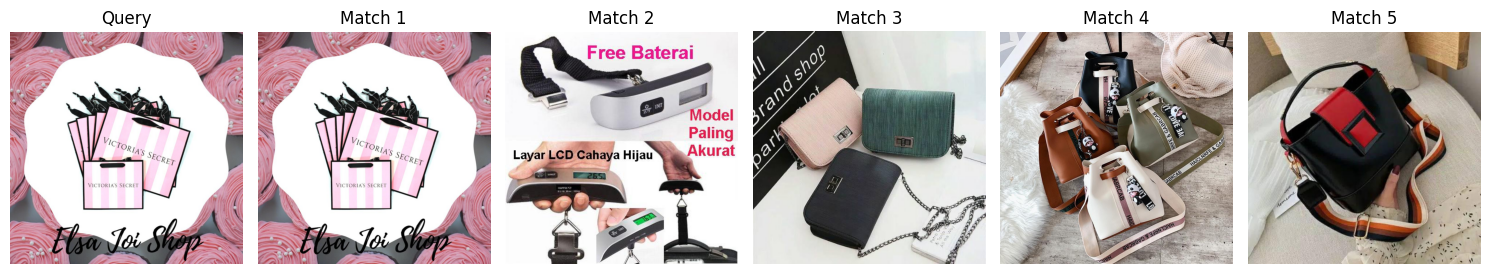


Visualizing results for query index 12 (train_2771755203)


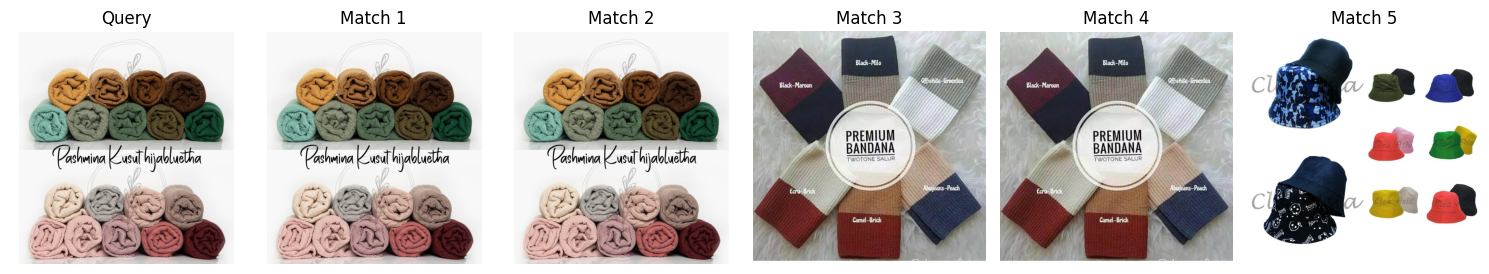


Visualizing results for query index 107 (train_1641797816)


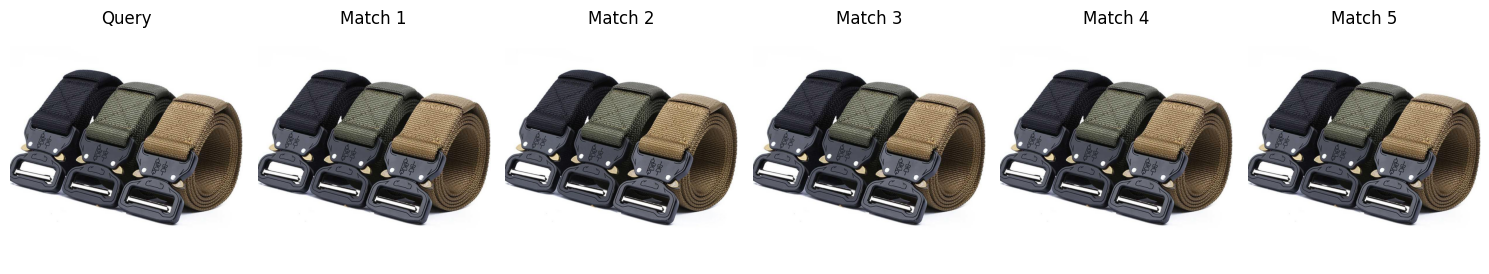


Visualizing results for query index 1 (train_3386243561)


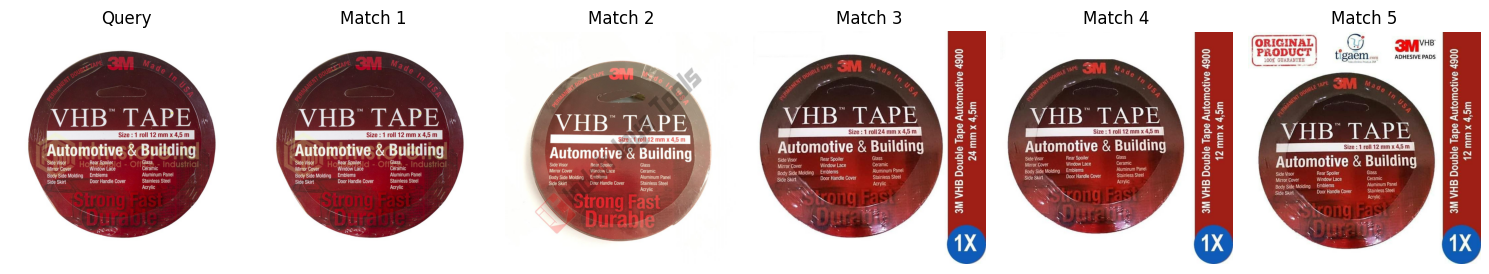


Visualizing results for query index 523 (train_2267612514)


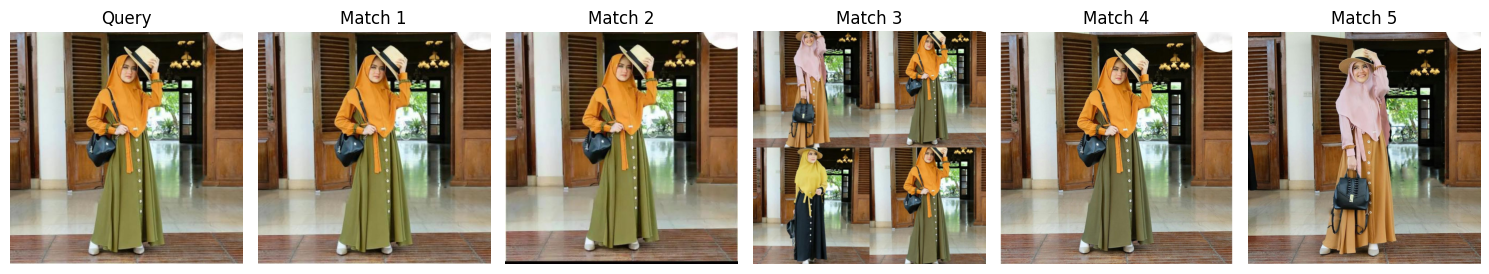


Visualizing results for query index 892 (train_312328234)


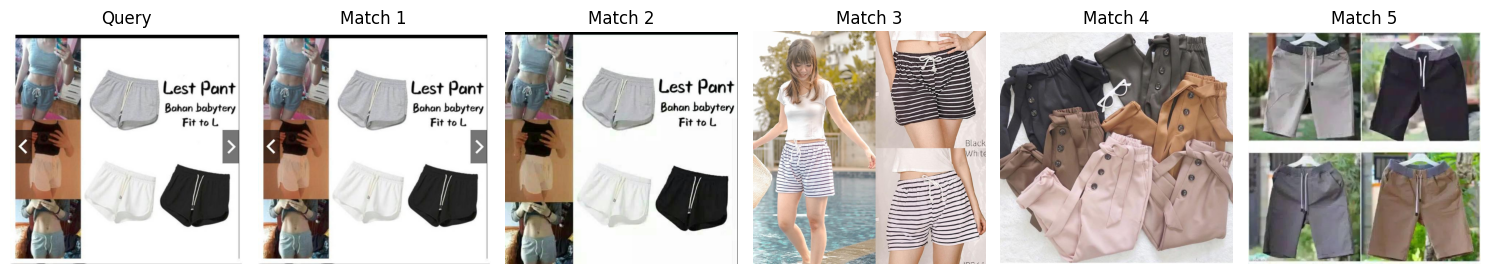


Visualizing results for query index 1430 (train_4035348093)


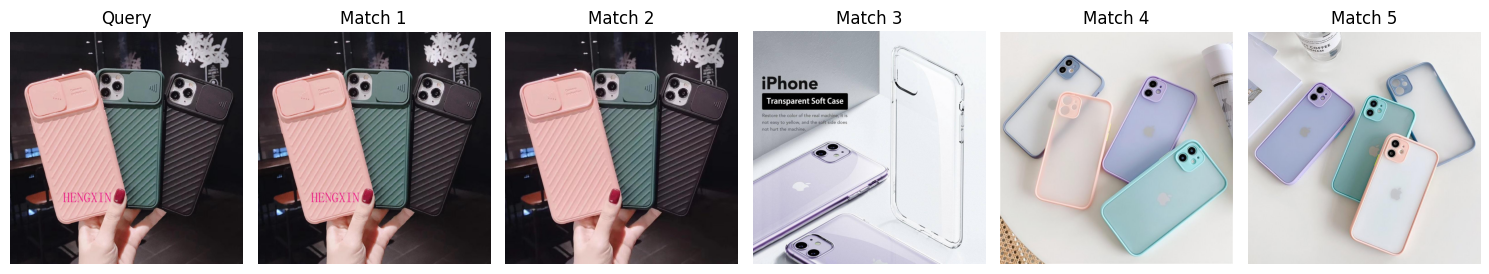

In [ ]:
# k-NN search
_, neighbors = gpu_idx.search(all_embs, K_NEIGHBORS)

# Neighborhood blending for final matches
matches = []
for i in range(len(df)):
    grp = {
        df.iloc[j]['posting_id']
        for j in neighbors[i]
        if cosine_similarity([all_embs[i]], [all_embs[j]])[0, 0] > THRESHOLD
    }
    matches.append(" ".join(grp))
df['matches'] = matches

# Save submission file
df[['posting_id', 'matches']].to_csv('/kaggle/working/submission.csv', index=False)
print("Wrote submission.csv")

# Evaluate with F1, Precision, Recall
label_map = df.set_index('posting_id')['label_group'].to_dict()
y_true, y_pred = [], []
for _, row in df.iterrows():
    for p in row['matches'].split():
        y_true.append(row['label_group'])
        y_pred.append(label_map.get(p, -1))

print("F1:", f1_score(y_true, y_pred, average='macro'))
print("Prec:", precision_score(y_true, y_pred, average='macro', zero_division=0))
print("Rec :", recall_score(y_true, y_pred, average='macro', zero_division=0))

# Visualization of sample matches for random input images
for query_idx in candidate_queries:
    print(f"\nVisualizing results for query index {query_idx} ({df.iloc[query_idx]['posting_id']})")
    fig, axes = plt.subplots(1, VISUAL_COUNT + 1, figsize=(15, 5))

    # Query image
    qpath = df.iloc[query_idx]['image_path']
    axes[0].imshow(Image.open(qpath))
    axes[0].set_title("Query")
    axes[0].axis('off')

    # Top neighbor matches
    for k, nb in enumerate(neighbors[query_idx][:VISUAL_COUNT], start=1):
        match_img = Image.open(df.iloc[nb]['image_path'])
        axes[k].imshow(match_img)
        axes[k].set_title(f"Match {k}")
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()
